<a href="https://colab.research.google.com/github/jadrzy/ProjectPythonForMachineLearning/blob/main/Notebooks/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import and data divison**

In [ ]:
import seaborn as sns
from time import time
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
MinMaxScaler,
StandardScaler,
)

!git clone https://{token}@github.com/jadrzy/PythonForMachineLearning.git

model_data = pd.read_csv("/content/PythonForMachineLearning/datasets/model_data.csv")
analize_data = pd.read_csv("/content/PythonForMachineLearning/datasets/analyze_data.csv")

analyze_data = analize_data.drop(['ID'], axis=1)
model_data = model_data.drop(['ID'], axis=1)

selected_model_data = model_data.copy()
selected_model_data = selected_model_data.loc[:, ~model_data.columns.str.startswith('Ethnicity')].drop(['Semeron', 'Country_Australia', 'Country_Canada', 'Country_New Zealand', 'Country_Other', 'Country_Republic of Ireland', 'Alcohol', 'Caffeine', 'Chocolate'], axis=1)

X1= selected_model_data.drop(['Age', 'Gender', 'Education', 'Neuroticism', 'Extraversion',
       'Openness to experience', 'Agreeableness', 'Conscientiousness',
       'Impulsiveness', 'Sensation seeking', 'Country_UK', 'Country_USA'], axis=1)

X2= selected_model_data.drop(['Cocaine', 'Crack', 'Ecstasy', 'Heroin',
       'Ketamine', 'Legal highs', 'LSD', 'Meth', 'Mushrooms', 'Nicotine',
       'Volatile substance abuse'], axis=1)

y= selected_model_data['Cannabis']

X_train, X_test, y_train, y_test= train_test_split(X2, y, test_size=0.4,random_state=1 )
X_valid, X_test, y_valid, y_test= train_test_split(X_test, y_test, test_size=0.5,random_state=1 )



Cloning into 'PythonForMachineLearning'...
remote: Enumerating objects: 352, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 352 (delta 116), reused 164 (delta 96), pack-reused 158 (from 1)
Receiving objects: 100% (352/352), 20.18 MiB | 7.39 MiB/s, done.
Resolving deltas: 100% (174/174), done.
Updating files: 100% (22/22), done.


# **CV + Grid Search**

## **Function**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

def train_classifier(clf, parameters, scoring, X):
  X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=1)

  y_train = X_train['Cannabis'] > 3  # 0 represent range of 0-3, 1 represent range of 4-6
  X_train = X_train.drop(columns=['Cannabis'])

  grid_search = GridSearchCV(clf, parameters, cv=5, scoring=scoring) #try with different scoring: 'accuracy','f1','recall','precision'
  grid_search.fit(X_train, y_train)

  cv_res = pd.DataFrame(grid_search.cv_results_)
  cv_res['params'] = cv_res['params'].apply(lambda x: ', '.join([f'{k}={v}' for k, v in x.items()]))
  selected_columns = ['params', 'mean_test_score', 'rank_test_score']
  sorted_results = cv_res[selected_columns].sort_values(by=['rank_test_score'])
  sorted_results = sorted_results.rename(columns={
      'params': 'parameters',
      'mean_test_score': scoring,
      'rank_test_score': 'rank'
  })
  new_selected_columns = ['parameters', scoring, 'rank']
  display(sorted_results[new_selected_columns])

## MLP

In [ ]:
clf1 = MLPClassifier();
parameters1 =  {'solver':('sgd', 'lbfgs', 'adam'), 'hidden_layer_sizes':[(5,5), (10,7)], 'max_iter': [200, 500, 700]}
scoring1 = 'a'

train_classifier(clf1, parameters1, scoring1, X1)
train_classifier(clf1, parameters1, scoring1, X2)


NameError: name 'MLPClassifier' is not defined

## SVM

In [ ]:
clf2 = svm.SVC()
parameters2 =  {'kernel':('linear', 'rbf', 'poly'), 'C':[0.1, 4, 8]}
scoring2 = 'accuracy'


train_classifier(clf2, parameters2, scoring2, X1)
train_classifier(clf2, parameters2, scoring2, X2)

,parameters,accuracy,rank
4,"C=4, kernel=rbf",0.804240,1
3,"C=4, kernel=linear",0.794979,2
6,"C=8, kernel=linear",0.794979,2
0,"C=0.1, kernel=linear",0.793650,4
1,"C=0.1, kernel=rbf",0.792308,5
7,"C=8, kernel=rbf",0.787004,6
2,"C=0.1, kernel=poly",0.769079,7
5,"C=4, kernel=poly",0.765783,8
8,"C=8, kernel=poly",0.764450,9


,parameters,accuracy,rank
5,"C=4, kernel=poly",0.793615,1
8,"C=8, kernel=poly",0.793606,2
0,"C=0.1, kernel=linear",0.789659,3
3,"C=4, kernel=linear",0.787015,4
6,"C=8, kernel=linear",0.786350,5
7,"C=8, kernel=rbf",0.785642,6
4,"C=4, kernel=rbf",0.773041,7
2,"C=0.1, kernel=poly",0.732587,8
1,"C=0.1, kernel=rbf",0.621113,9


# **Evaluate**

## **Function**

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import cross_val_score, cross_validate
import numpy as np

def evaluate_classifier(clf, X):
  X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=1)

  y_train = X_train['Cannabis'] > 3
  X_train = X_train.drop(columns=['Cannabis'])
  y_test = X_test['Cannabis'] > 3
  X_test = X_test.drop(columns=['Cannabis'])

  scores = cross_validate(clf, X_train, y_train, cv=5, scoring=['accuracy','f1','recall','precision'])

  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

  print(f"Accurancy: {np.mean(scores['test_accuracy'])}")
  print(f"F1: {np.mean(scores['test_f1'])}")
  print(f"Recall: {np.mean(scores['test_recall'])}")
  print(f"Precision: {np.mean(scores['test_precision'])}")
  print("")

  cm = confusion_matrix(y_test, y_pred)
  cm_display = ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)

  RocCurveDisplay.from_estimator(clf, X_test, y_test)
  plt.show()

  PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)
  plt.show()

## MLP

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Accurancy: 0.8009328727640757
F1: 0.7652313867618052
Recall: 0.7771428571428572
Precision: 0.7562700348338917



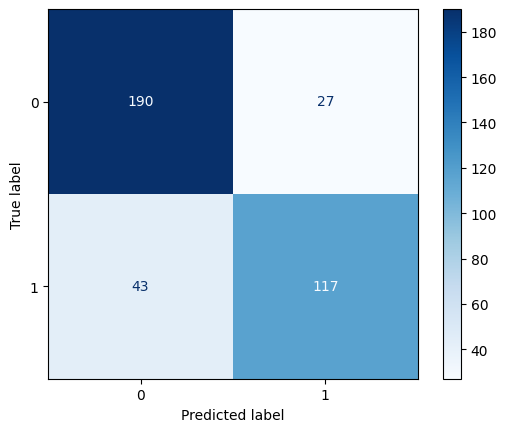

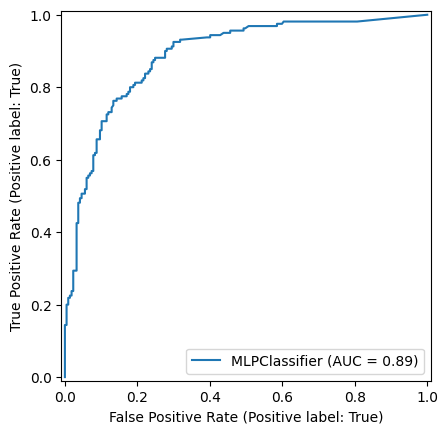

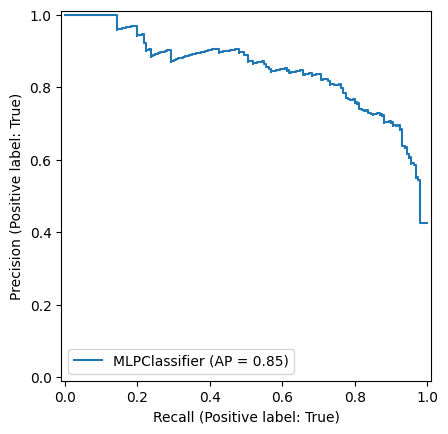

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

Accurancy: 0.7836681261138368
F1: 0.7580166099987018
Recall: 0.8121142857142857
Precision: 0.7130899815338714



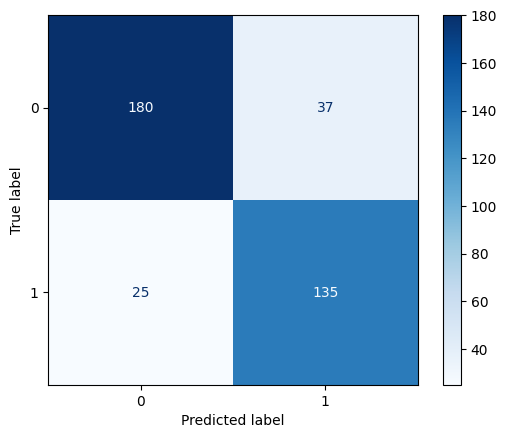

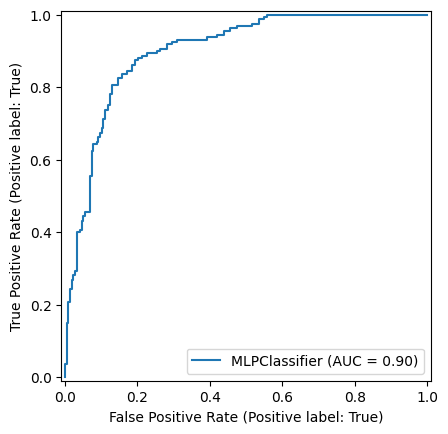

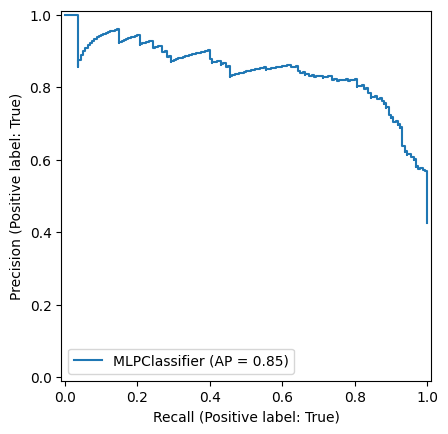

In [ ]:
clf1 = MLPClassifier(hidden_layer_sizes=(10, 7), max_iter=500, solver='sgd')
clf2 = MLPClassifier(hidden_layer_sizes=(10, 7), max_iter=700, solver='lbfgs')

evaluate_classifier(clf1, X1)
evaluate_classifier(clf2, X2)

## SVM

Accurancy: 0.8042397306989943
F1: 0.7635633022955896
Recall: 0.7595809523809522
Precision: 0.7694648628873562



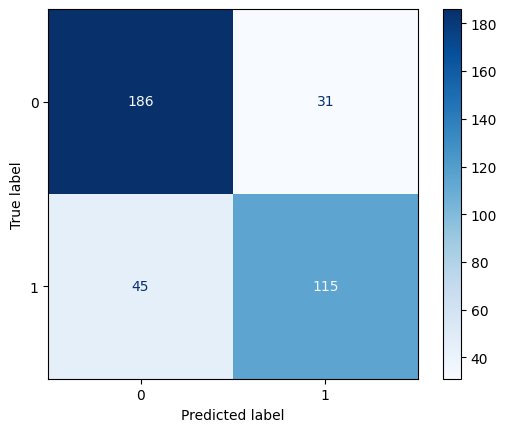

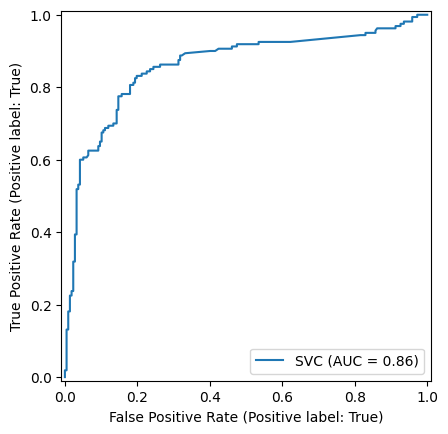

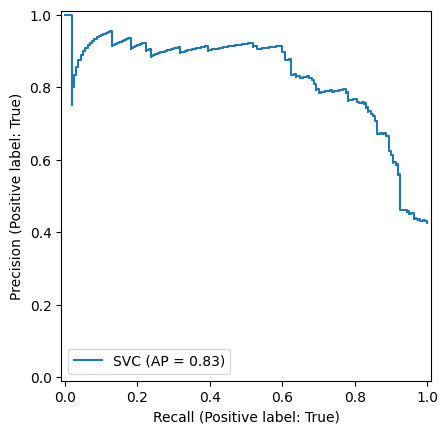

Accurancy: 0.7936151019779543
F1: 0.7542261312836235
Recall: 0.759479365079365
Precision: 0.7509367048346056



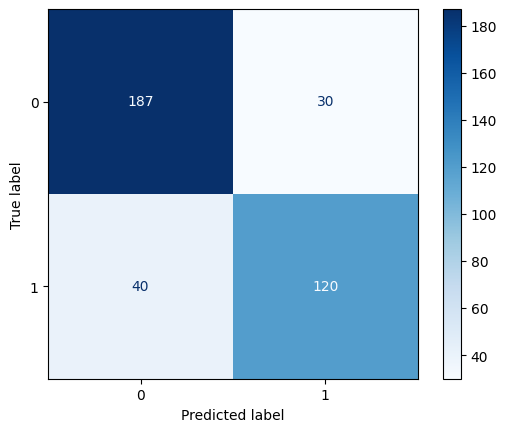

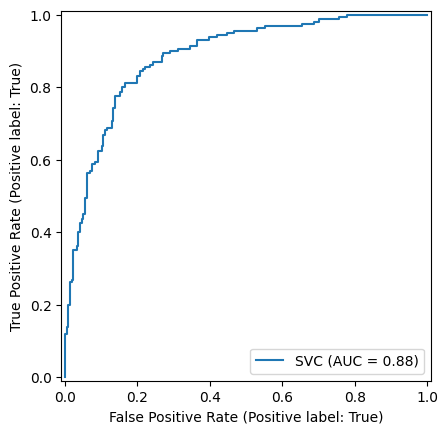

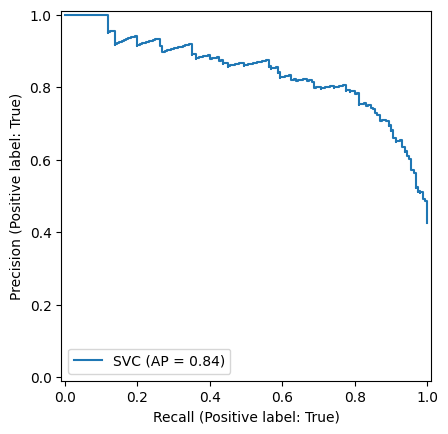

In [ ]:
clf1 = svm.SVC(C=4, kernel='rbf')
clf2 = svm.SVC(C=4, kernel='poly')

evaluate_classifier(clf1, X1)
evaluate_classifier(clf2, X2)